In [ ]:
# Установка необходимых библиотек
pip install yadisk --quiet

In [ ]:
pip install livelossplot --quiet

In [ ]:
# Импорт необходимых библиотек
import torch
from torch import nn
from torch import optim
from livelossplot import PlotLosses
import torchvision as tv
import time
import os
import yadisk
import tqdm.notebook as tqdm
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from PIL import Image
%matplotlib inline

Загрузка датасета

In [ ]:
# Константы и параметы
token_ya ="AgAAAAAEmIbuAAZqsLC2BS8SQU_woAdey85OBsI" # Токен Яндекс диска
data_dir = './Dataset'
dataset_file = 'Dataset.zip'

In [ ]:
# Загрузка файла с датасетом

y = yadisk.YaDisk(token=token_ya)
print("Downloading", dataset_file, 'from Yandex.Disk')
y.download('/'+ dataset_file, dataset_file)
print("Unpacking", dataset_file, "...")
!unzip -q Dataset.zip
print("Deleting", dataset_file, "...")
if os.path.isfile(dataset_file):
    os.remove(dataset_file)
    print("Delete", dataset_file)
else:    ## Show an error ##
    print("Error: %s file not found" % myfile)

Unpacking Dataset.zip ...
Deleting Dataset.zip ...
Delete Dataset.zip


In [ ]:
# Служебная функция, потом удалить
# Удаление папки Dataset

if os.path.exists(data_dir ) and os.path.isdir(data_dir):
    shutil.rmtree(data_dir )

Приведение данных к необходимому формату

In [ ]:
print(os.listdir(data_dir ))

['Saintpaulia', 'Phalaenopsis', 'Ficus']


In [ ]:
# Переименование файлов с разбивкой по классам
def rename_files(root_dir):
    classes = os.listdir(root_dir)
    for classes in classes:
        for file in os.listdir(root_dir + '/' + classes):
            if file.endswith('jpg'):
                os.rename((root_dir + '/' + classes + '/' + file),(root_dir + '/' + classes + '/' + classes + "_" + file))

rename_files(data_dir)

In [ ]:
def parse_species(fname):
    parts = fname.split('_')
    return parts[0]

def open_image(path):
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')

class FlowersDataset(Dataset):
    def __init__(self, root_dir, transform):
        super().__init__()
        self.root_dir = root_dir
        self.files = []
        self.classes = [fname for fname in os.listdir(root_dir) if fname != 'flowers']
        for classes in self.classes:
            for file in os.listdir(root_dir + '/' + classes):
                if file.endswith('jpg'):
                    self.files.append(file)
        self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, i):
        fname = self.files[i]
        species = parse_species(fname)
        fpath = os.path.join(self.root_dir, species, fname)
        img = self.transform(open_image(fpath))
        class_idx = self.classes.index(species)
        return img, class_idx

In [ ]:
stats = ((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
normalize = tv.transforms.Normalize(*stats, inplace=True)
transoforms = tv.transforms.Compose([
    tv.transforms.RandomHorizontalFlip(),
    tv.transforms.RandomVerticalFlip(),
    tv.transforms.ToTensor(),
    normalize
    ])

transoforms_pred = tv.transforms.Compose([
    tv.transforms.ToTensor(),
    normalize
    ])

dataset = FlowersDataset(data_dir, transform=transoforms)

In [ ]:
print("Датасет состит из" ,len(dataset))

Датасет состит из 522


In [ ]:
def denormalize(images, means, stds):
    if len(images.shape) == 3:
        images = images.unsqueeze(0)
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means

def show_image(img_tensor, label):
    print('Label:', dataset.classes[label], '(' + str(label) + ')')
    img_tensor = denormalize(img_tensor, *stats)[0].permute((1, 2, 0))
    plt.imshow(img_tensor)

Label: Saintpaulia (0)


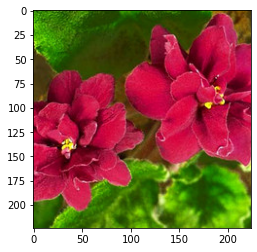

In [ ]:
show_image(*dataset[16]);

Data Loaders


In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

In [ ]:
from torch.utils.data import random_split

random_seed = 20
torch.manual_seed(random_seed)

val_pct = 0.2
val_size = int(val_pct * len(dataset))
train_size = len(dataset) - val_size

In [ ]:
train_ds, valid_ds= random_split(dataset, [train_size, val_size])
len(train_ds), len(valid_ds)

(418, 104)

In [ ]:
# Внимание! Если считаем на CPU то num_workers=0. Если на GPU num_workers=3.

batch_size = 32

if device == "cpu":
  train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=0, pin_memory=True)
  valid_dl = DataLoader(valid_ds, batch_size*2, num_workers=0, pin_memory=True)
else:
  train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)
  valid_dl = DataLoader(valid_ds, batch_size*2, num_workers=3, pin_memory=True)

dataloaders = {
    "train": train_dl,
    "validation": valid_dl
}

In [ ]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        images = denormalize(images, *stats)
        ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0))
        break

Traceback (most recent call last):


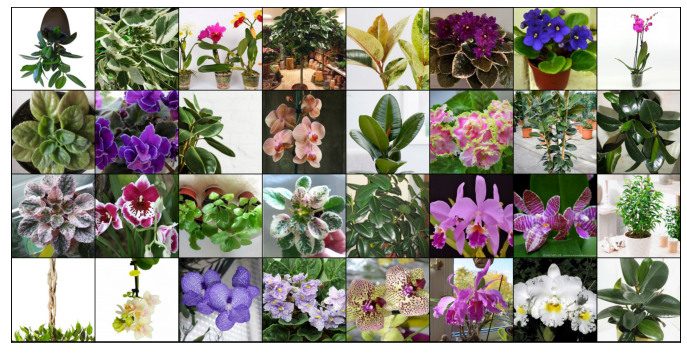

In [ ]:
show_batch(train_dl)

Формируем модель Model Architecture  ResNet18

In [ ]:
model = tv.models.resnet18(pretrained=True)

In [ ]:
## Убираем требование градиента:
for param in model.parameters():
    param.requires_grad = False

In [ ]:
model.fc = nn.Linear(in_features=512, out_features=4)

In [ ]:
model.named_modules

In [ ]:
params_to_update = []
for name,param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)

Тренируем модель

In [ ]:
def train_model(model, criterion, optimizer, num_epochs=10):
    liveloss = PlotLosses()
    model = model.to(device)
    
    for epoch in range(num_epochs):
        logs = {}
        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                _, preds = torch.max(outputs, 1)
                running_loss += loss.detach() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.float() / len(dataloaders[phase].dataset)
            
            prefix = ''
            if phase == 'validation':
                prefix = 'val_'

            logs[prefix + 'log loss'] = epoch_loss.item()
            logs[prefix + 'accuracy'] = epoch_acc.item()
        
        liveloss.update(logs)
        liveloss.send()

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.003)

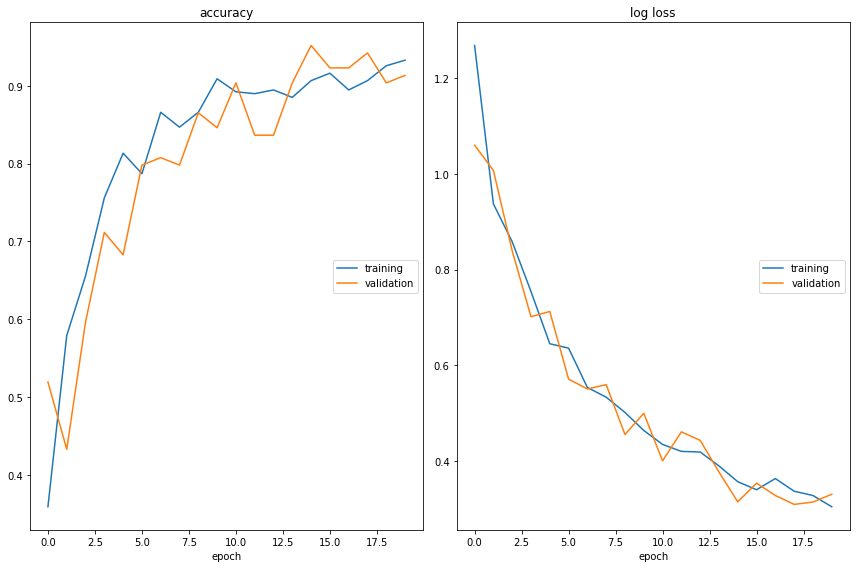

accuracy
	training         	 (min:    0.359, max:    0.933, cur:    0.933)
	validation       	 (min:    0.433, max:    0.952, cur:    0.913)
log loss
	training         	 (min:    0.304, max:    1.269, cur:    0.304)
	validation       	 (min:    0.309, max:    1.060, cur:    0.330)


In [ ]:
train_model(model, criterion, optimizer, num_epochs=20)

In [ ]:
# Функция предсказания картинки
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]

Label: Phalaenopsis , Predicted: Phalaenopsis


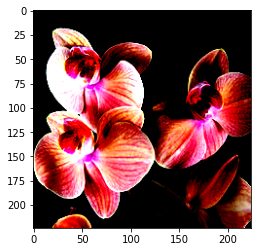

In [ ]:
# Предсказываем картинку
img, label = valid_ds[52]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

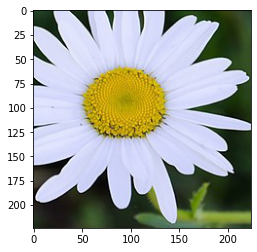

In [ ]:
# Загрузка картинки из папки и показ
path = './Pictures/Image03.jpg'
with open(path, 'rb') as f:
    img = Image.open(f)
    img.convert('RGB')
plt.imshow(img)

In [ ]:
# Перегоняем в тензор с нормализацией и трансформацией
img = transoforms_pred(img)

Predicted: Phalaenopsis


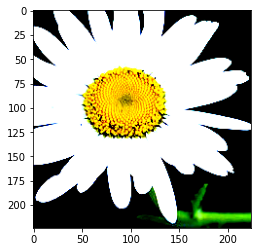

In [ ]:
# Предсказываем картинку

plt.imshow((img.permute(1, 2, 0).clamp(0, 1)))
print('Predicted:', predict_image(img, model))

In [ ]:
# https://stackoverflow.com/questions/42703500/best-way-to-save-a-trained-model-in-pytorch?newreg=e978ffd881af4cb6833f6ae071bebc63

# Case # 1: Save the model to use it yourself for inference:
model_dir = './Model/Case_1/model.pth'
torch.save(model.state_dict(), model_dir)

# Later to restore:
# model.load_state_dict(torch.load(filepath))
# model.eval()

In [ ]:
# Case # 2: Save model to resume training later
model_dir = './Model/Case_2/model.pth'
state = {
    'state_dict': model.state_dict()
    }
torch.save(state, model_dir)

In [ ]:
# Case # 3: Model to be used by someone else with no access to your code
model_dir = './Model/Case_3/model.pth'
torch.save(model, model_dir)